In [1]:
import jqdatasdk as jds
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn as skl

# eft复权后取平价合约和直接利用沽购合约价差最小取平价合约的结果不一定相同！！！

pd.set_option('display.max_columns', 30)

start = pd.to_datetime('20210301')
end = pd.to_datetime('20210803')
tdy = datetime.now()
symbol = "510050.XSHG"


In [2]:
class VIXDaily():
    def __init__(self, underlying_asset: str, startdate, enddate):
        # symbol is the underlying assets of option
        # startdate: VIX start time
        # enddate: VIX end time
        self.ID = '18810592263'
        self.pwd = '592263'
        jds.auth(self.ID, self.pwd)
        self.R = 0.02  # 无风险利率 约为1年期中国国债

        self.fields = ['code', 'name', 'exercise_price', 'contract_type', 'list_date']
        self.chosen = ['pre_settle', 'settle_price', 'change_pct_settle', 'pre_close', 'open', 'close', 'volume', ]

        # 筛选历史合约信息
        q = jds.query(jds.opt.OPT_CONTRACT_INFO)\
            .filter((jds.opt.OPT_CONTRACT_INFO.underlying_symbol == underlying_asset))
        self.history_option = jds.opt.run_query(q)

        # history_option.sort_values(by=['list_date', 'trading_code'])
        column = ['code', 'name', 'exercise_price', 'list_date', 'expire_date', 'contract_type']
        self.expire_dates = self.history_option.expire_date.drop_duplicates().sort_values().values
        self.list_dates = self.history_option.list_date.drop_duplicates().sort_values().values
        self.history_option = self.history_option.reindex(columns=column).set_index(['expire_date',])
        # print(history_option)

        #取历史合约行情
        self.tradedays = jds.get_trade_days(start_date=startdate, end_date=enddate)
        # for i in np.arange(len(self.tradedays)):
        #     self.tradedays[i] = datetime(self.tradedays[i].year, self.tradedays[i].month, self.tradedays[i].day, )
        # print(self.tradedays)
        self.Vix = [0]*len(self.tradedays)

    def start(self):
        # 初始化
        date = self.tradedays[0]
        self.getOption(date)
        self.Vix[0] = self.evaluation(date)

    def forward(self):
        for i in np.arange(1, self.tradedays.size):
            date = self.tradedays[i]
            if date in self.expire_dates or date in self.list_dates:
                self.getOption(date)
            self.Vix[i] = self.evaluation(date)

    def getOption(self, trading_date):
        # 初始化
        self.neartermExpireDate, self.nexttermExpireDate = self.expire_dates[self.expire_dates >= trading_date][:2]

        self.neartermOption = self.history_option.loc[self.neartermExpireDate, :].reindex(
            columns=self.fields).sort_values(by='name')
        self.neartermOption = self.neartermOption[self.neartermOption.list_date <= trading_date]
        self.nexttermOption = self.history_option.loc[self.nexttermExpireDate, :].reindex(
            columns=self.fields).sort_values(by='name')
        self.nexttermOption = self.nexttermOption[self.nexttermOption.list_date <= trading_date]
        self.neartermOptionPrice = pd.DataFrame()
        self.nexttermOptionPrice = pd.DataFrame()
        for Option in self.neartermOption.loc[:, 'code']:
            que = jds.query(jds.opt.OPT_DAILY_PRICE).filter(
                (jds.opt.OPT_DAILY_PRICE.code == Option) & (jds.opt.OPT_DAILY_PRICE.date >= trading_date))
            self.neartermOptionPrice = pd.concat([self.neartermOptionPrice, jds.opt.run_query(que)])
        for Option in self.nexttermOption.loc[:, 'code']:
            que = jds.query(jds.opt.OPT_DAILY_PRICE).filter(
                (jds.opt.OPT_DAILY_PRICE.code == Option) & (jds.opt.OPT_DAILY_PRICE.date >= trading_date))
            self.nexttermOptionPrice = pd.concat([self.nexttermOptionPrice, jds.opt.run_query(que)])
        # for i in self.neartermOptionPrice.index:
        #     for t in np.arange(len(self.neartermOptionPrice.loc[i, 'date'])):
        #         self.neartermOptionPrice.loc[i, 'date'][t] = self.neartermOptionPrice.loc[i, 'date'][t].date()
        # for i in self.nexttermOptionPrice.index:
        #     for t in np.arange(len(self.nexttermOptionPrice.loc[i, 'date'])):
        #         self.nexttermOptionPrice.loc[i, 'date'][t] = self.nexttermOptionPrice.loc[i, 'date'][t].date()


        self.neartermOptionPrice = self.neartermOptionPrice.set_index(['code', 'date']).loc[:, self.chosen]
        self.nexttermOptionPrice = self.nexttermOptionPrice.set_index(['code', 'date']).loc[:, self.chosen]

        # print(neartermOption)
        # print(nexttermOptionPrice.loc['10000841.XSHG', :])

    def evaluation(self, trading_date):
        # 取平价合约
        tempP = self.neartermOption.reset_index().set_index('contract_type').loc[
            'PO', ['exercise_price', 'code', 'name']].set_index('exercise_price')
        tempC = self.neartermOption.reset_index().set_index('contract_type').loc[
            'CO', ['exercise_price', 'code', 'name']].set_index('exercise_price')
        nearOptionEval = pd.concat({'C': tempC, 'P': tempP}, axis=1)
        difference = [0] * len(nearOptionEval)
        Q = [0] * len(nearOptionEval)
        DeltaK = [0] * len(nearOptionEval)
        for i in np.arange(len(nearOptionEval)):
            row = nearOptionEval.iloc[i, :]
            difference[i] = self.neartermOptionPrice.loc[((row[('C', 'code')]), pd.to_datetime(trading_date)), 'settle_price'] - \
                            self.neartermOptionPrice.loc[((row[('P', 'code')]), pd.to_datetime(trading_date)), 'settle_price']

        nearOptionEval['diff'] = difference
        K0near = nearOptionEval.iloc[np.argmin(np.abs(difference)), :]

        for i in np.arange(len(nearOptionEval)):
            p = K0near.name
            row = nearOptionEval.iloc[i, :]
            Q[i] = self.neartermOptionPrice.loc[((row[('C', 'code')]), pd.to_datetime(trading_date)), 'close'] if row.name > p else \
            self.neartermOptionPrice.loc[((row[('P', 'code')]), pd.to_datetime(trading_date)), 'close']
            if i == 0:
                DeltaK[i] = (nearOptionEval.index[i + 1] - nearOptionEval.index[i]) / 2
            elif i == len(nearOptionEval) - 1:
                DeltaK[i] = (nearOptionEval.index[i] - nearOptionEval.index[i - 1]) / 2
            else:
                DeltaK[i] = (nearOptionEval.index[i + 1] - nearOptionEval.index[i - 1]) / 2
        nearOptionEval['Q'] = Q
        nearOptionEval['DeltaK'] = DeltaK

        tempP = self.nexttermOption.reset_index().set_index('contract_type').loc[
            'PO', ['exercise_price', 'code', 'name']].set_index('exercise_price')
        tempC = self.nexttermOption.reset_index().set_index('contract_type').loc[
            'CO', ['exercise_price', 'code', 'name']].set_index('exercise_price')
        nextOptionEval = pd.concat({'C': tempC, 'P': tempP}, axis=1)

        difference = [0] * len(nextOptionEval)
        Q = [0] * len(nextOptionEval)
        DeltaK = [0] * len(nextOptionEval)
        for i in np.arange(len(nextOptionEval)):
            row = nextOptionEval.iloc[i, :]
            difference[i] = self.nexttermOptionPrice.loc[((row[('C', 'code')]), pd.to_datetime(trading_date)), 'settle_price'] - \
                            self.nexttermOptionPrice.loc[((row[('P', 'code')]), pd.to_datetime(trading_date)), 'settle_price']

        nextOptionEval['diff'] = difference  # diff 字段用于求F
        K0next = nextOptionEval.iloc[np.argmin(np.abs(difference)), :]

        for i in np.arange(len(nextOptionEval)):
            p = K0next.name
            row = nextOptionEval.iloc[i, :]
            Q[i] = self.nexttermOptionPrice.loc[((row[('C', 'code')]), pd.to_datetime(trading_date)), 'close'] if row.name > p \
                else self.nexttermOptionPrice.loc[((row[('P', 'code')]), pd.to_datetime(trading_date)), 'close']
            if i == 0:
                DeltaK[i] = (nextOptionEval.index[i + 1] - nextOptionEval.index[i]) / 2
            elif i == len(nextOptionEval) - 1:
                DeltaK[i] = (nextOptionEval.index[i] - nextOptionEval.index[i - 1]) / 2
            else:
                DeltaK[i] = (nextOptionEval.index[i + 1] - nextOptionEval.index[i - 1]) / 2
        nextOptionEval['Q'] = Q
        nextOptionEval['DeltaK'] = DeltaK

        Tnear = (self.neartermExpireDate - trading_date).days / 365
        Tnext = (self.nexttermExpireDate - trading_date).days / 365

        Fnear = float(K0near.name + np.exp(self.R * Tnear) * K0near['diff'])
        Fnext = float(K0next.name + np.exp(self.R * Tnext) * K0next['diff'])

        nearOptionEval = nearOptionEval.reset_index()
        nextOptionEval = nextOptionEval.reset_index()

        if Tnear != 0:
            sigma_near = 2 / Tnear * (nearOptionEval.DeltaK / (nearOptionEval.exercise_price ** 2) * np.exp(
                self.R * Tnear) * nearOptionEval.Q).sum() - 1 / Tnear * (Fnear / K0near.name - 1) ** 2
        else:
            sigma_near = 0
        sigma_next = 2 / Tnext * (nextOptionEval.DeltaK / (nextOptionEval.exercise_price ** 2) * np.exp(
            self.R * Tnear) * nextOptionEval.Q).sum() - 1 / Tnext * (Fnext / K0next.name - 1) ** 2

        sigma = 100*np.sqrt(1/30*(Tnear*sigma_near*(Tnext-30)/(Tnext-Tnear)+Tnext*sigma_next*(30-Tnear)/(Tnext-Tnear)))

        return [sigma_near, sigma_next, sigma, nearOptionEval, nextOptionEval]


    def getETF(self, security:str, start, end):
        self.etfPrice = jds.get_price(security, start, end, 'daily', fq='pre', panel=False)
        self.etfPrice['change'] = self.etfPrice.close.diff()
        self.etfPrice['pctchange'] = self.etfPrice.change/self.etfPrice.close.shift(1)
        print(self.etfPrice)

In [3]:
K = VIXDaily(underlying_asset=symbol, startdate=start, enddate=end)
K.start()
K.forward()
vix = pd.Series(np.zeros(len(K.Vix)), index=K.tradedays)
for i in np.arange(len(K.tradedays)):
    day = K.tradedays[i]
    vix[day] = K.Vix[i][2]

auth success 


In [4]:
K.getETF(symbol, start, end)

             open  close   high    low        volume         money  change  \
2021-03-01  3.777  3.773  3.780  3.737  4.006001e+08  1.507765e+09     NaN   
2021-03-02  3.795  3.707  3.796  3.672  6.433687e+08  2.391797e+09  -0.066   
2021-03-03  3.700  3.804  3.806  3.698  5.171484e+08  1.945427e+09   0.097   
2021-03-04  3.765  3.698  3.772  3.677  7.159516e+08  2.659109e+09  -0.106   
2021-03-05  3.650  3.678  3.712  3.616  6.257017e+08  2.294065e+09  -0.020   
...           ...    ...    ...    ...           ...           ...     ...   
2021-07-28  3.152  3.183  3.200  3.126  1.375378e+09  4.360823e+09   0.027   
2021-07-29  3.229  3.212  3.232  3.189  1.027235e+09  3.296129e+09   0.029   
2021-07-30  3.190  3.163  3.190  3.146  5.258982e+08  1.664828e+09  -0.049   
2021-08-02  3.150  3.242  3.250  3.120  1.170402e+09  3.764607e+09   0.079   
2021-08-03  3.228  3.254  3.268  3.213  5.563126e+08  1.804724e+09   0.012   

            pctchange  
2021-03-01        NaN  
2021-03-02  -0.

0.38027628592794477


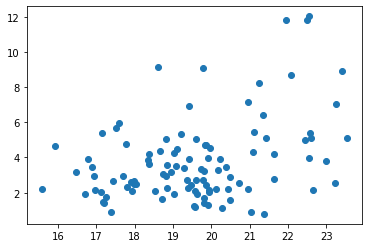

In [34]:
# plt.plot(vix)

vola = (K.etfPrice.close.rolling(window=5, ).aggregate('std')*100)

# plt.plot(vola)
plt.scatter(vix, vola)

print(vola.corr(vix))

plt.show()